In [1]:
#!pip install pytorch-minimize

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import proxy_crm_modules as pCRM
import pywaterflood.pywaterflood as pwf

from timeit import default_timer as timer

d:\crmProject\crmp_code_test\proxy_crm\main\proxy_crm_modules.py:444: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(parallel=True)


In [3]:
np.set_printoptions(threshold=np.inf)

<h3><b>1. Data Preprocessing</b></h3>
<p>Here, we process data for better understanding of the structure and plan out the things we need to do toward the data. P2 and P4 are modified to replicate shut in condition.</p>

In [4]:
data_src = "D:/crmProject/dataSamples/pywaterflood-master/testing/data/"
prod = pd.read_csv(data_src + "production.csv", header= None)
inj = pd.read_csv(data_src + "injection.csv", header=None)
time = pd.read_csv(data_src + "time.csv", header= None)

train_size = int(0.75 * prod.shape[0])

<p>You can comment and uncomment this section to create one well shut-in and two well shut-in cases.</p>

In [5]:
prod_shut_in = pd.read_csv(data_src + "production.csv", header= None)

#Get the column as a NumPy array
column_val4 = prod_shut_in[3].to_numpy()
#column_val2 = prod_shut_in [1].to_numpy()

# Pad the array with zeros at the middle
i = (len(prod_shut_in)//2)
padded_val4 = np.insert(column_val4, i, np.zeros(20))
prod_shut_in[3] = padded_val4[:len(prod_shut_in[3])]

#padded_val2 = np.insert(column_val2, i, np.zeros(2))
#prod_shut_in[1] = padded_val2[:len(prod_shut_in[1])]

In [6]:
inj_shut_in = pd.read_csv(data_src + "injection.csv", header= None)

num_rows = len(inj_shut_in)
mid_idx = num_rows//2
num_rows_mid = 10

start_index = max(0, mid_idx - num_rows_mid)
end_index = min(num_rows, mid_idx + num_rows_mid + 1)
"""inj_shut_in.iloc[start_index:end_index, 2] = inj_shut_in.iloc[start_index:end_index, 2] + inj_shut_in.iloc[start_index:end_index, 2] * 0.17
inj_shut_in.iloc[start_index:end_index, 0] = inj_shut_in.iloc[start_index:end_index, 0] + inj_shut_in.iloc[start_index:end_index, 0] * 0.17"""

'inj_shut_in.iloc[start_index:end_index, 2] = inj_shut_in.iloc[start_index:end_index, 2] + inj_shut_in.iloc[start_index:end_index, 2] * 0.17\ninj_shut_in.iloc[start_index:end_index, 0] = inj_shut_in.iloc[start_index:end_index, 0] + inj_shut_in.iloc[start_index:end_index, 0] * 0.17'

In [7]:
pressure = 1000-prod*0.1

pressure_sh = 1000-prod_shut_in*0.1

<p>Now, we can split it into train-test data. It is divided into 75-25%</p>

In [8]:
#Create train-test dataset for non-shut-in.
inj_train = inj.values[1:train_size]
prod_train = prod.values[1:train_size]
time_train = time.values[1:train_size]
press_train = pressure.values[1:train_size]

inj_test = inj.values[train_size:]
prod_test = prod.values[train_size:]
time_test = time.values[train_size:]
press_test = pressure.values[train_size:]

# for shut-in.
inj_shut_in_train = inj_shut_in.values[1:train_size]
prod_shut_in_train = prod_shut_in.values[1:train_size]
press_sh_train = pressure_sh.values[1:train_size]

inj_shut_in_test = inj_shut_in.values[train_size:]
prod_shut_in_test = prod_shut_in.values[train_size:]
press_sh_test = pressure_sh.values[train_size:]

<h3><b>2A. Fitting Model - Base Case</b></h3>
<p>Now, let us start with base case, where there is no shut-in well.</p>

In [9]:
proxy_crm = pCRM.proxyCRM()

In [10]:
proxy_crm.fit(prod_train, inj_train, press_train, time_train[:,0], num_cores=4)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.03719140411628317
        x: [ 3.320e-01  3.243e-01 ...  1.000e-04  1.000e-04]
      nit: 82
      jac: [ 4.049e-03 -1.260e-04 ...  5.008e-03  6.015e-03]
     nfev: 3293
     njev: 89
 hess_inv: <36x36 LbfgsInvHessProduct with dtype=float64>]

lambda_ip: [0.33203275 0.3242568  0.24536481 0.16621398 0.1804843  0.3320865
 0.16553844 0.24520287 0.32515027 0.1805979  0.17375437 0.32444839
 0.24545076 0.16634405 0.33844695 0.17343428 0.16661024 0.24552671
 0.32534107 0.33795578]
tau: [9.99732895 9.99722636 9.99745584 9.99737697]
lambda_prod: [1. 1. 1. 1.]
tau_prim: [10. 10. 10. 10.]
prod index: [0.0001 0.0001 0.0001 0.0001]


[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:  3.4min


In [11]:
q_hat_train = proxy_crm.predict()
q_hat_test = proxy_crm.predict(inj = inj_test, time = time_test[:,0], prod=prod_test, press=press_test)

<h3><b>2B. Fitting Model - Shut-in Case</b></h3>
<p>This time, we will be fitting model in shut-in case. There are two shut-in cases, one well (P2) shut-in and two wells (P2 and P4) shut-in.</p>

In [12]:
start = timer()
shut_in_test = pCRM.proxyCRM()
shut_in_test.fit(prod_shut_in_train, inj_train, press_sh_train, time_train[:,0],num_cores=4)
end = timer()
print(end-start)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 3.513986590746873
        x: [ 3.615e-01  3.647e-01 ...  1.000e-04  4.780e+00]
      nit: 173
      jac: [-1.622e-03  4.154e-03 ...  1.028e-02  1.289e-04]
     nfev: 6845
     njev: 185
 hess_inv: <36x36 LbfgsInvHessProduct with dtype=float64>]

lambda_ip: [0.36154271 0.36466988 0.31513458 0.18808545 0.         0.27924639
 0.23810807 0.32927547 0.31738397 0.05621106 0.23033399 0.41096653
 0.34946771 0.19837604 0.04242727 0.0998964  0.1201291  0.
 0.17642098 0.84341755]
tau: [9.97437967 9.99231298 9.98251128 9.99996211]
lambda_prod: [1.         1.         1.         0.99999903]
tau_prim: [10.         10.         10.          9.99999903]
prod index: [1.00000000e-04 1.78326536e+00 1.00000000e-04 4.77967259e+00]
478.7345391000017


[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:  8.0min


In [13]:
q_hat_sh_test = shut_in_test.predict(inj = inj_test, time = time_test[:,0], prod = prod_shut_in_test, press= press_sh_test)
q_hat_sh_train = shut_in_test.predict()

In [14]:
arr = np.array([[2,3,4],[4,5,6]])

print(arr[1,:])

[4 5 6]


<h3><b>3. Display Results</b></h3>
<p>Let's display all of the results that we have gotten now!</p>

In [15]:
import scienceplots
plt.style.use(['science', 'no-latex'])

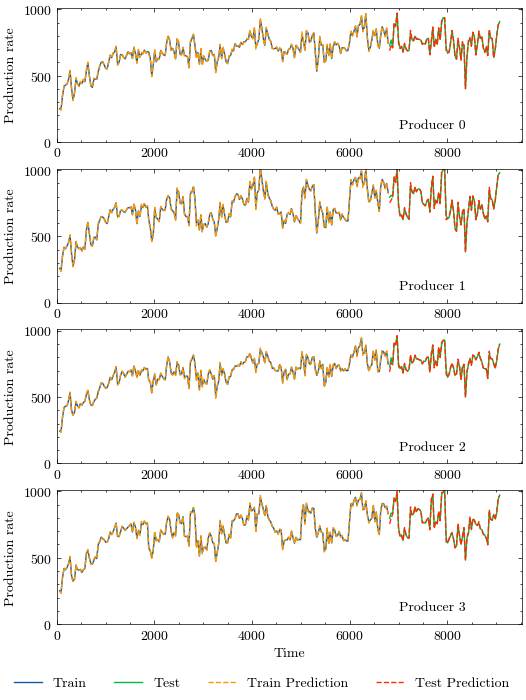

In [16]:
fig, axes = plt.subplots(len(prod.columns), figsize=(6, 8), sharey=True)
for i, p in enumerate(prod):
    axes[i].plot(time_train, prod_train[:,p], label=f"Train")
    axes[i].plot(time_test, prod_test[:,p], label=f"Test")
    axes[i].plot(time_train, q_hat_train[:,p], ls="--", label=f"Train Prediction")
    axes[i].plot(time_test, q_hat_test[:,p], ls="--", label=f"Test Prediction")
    axes[i].set(xlim=(0, None), ylim=(0, None), ylabel="Production rate")
    axes[i].annotate(f"Producer {p}", xy=(7000, 100))
axes[i].set(xlabel="Time")
legend = axes[i].legend(bbox_to_anchor =(1, -0.3), ncol=4)

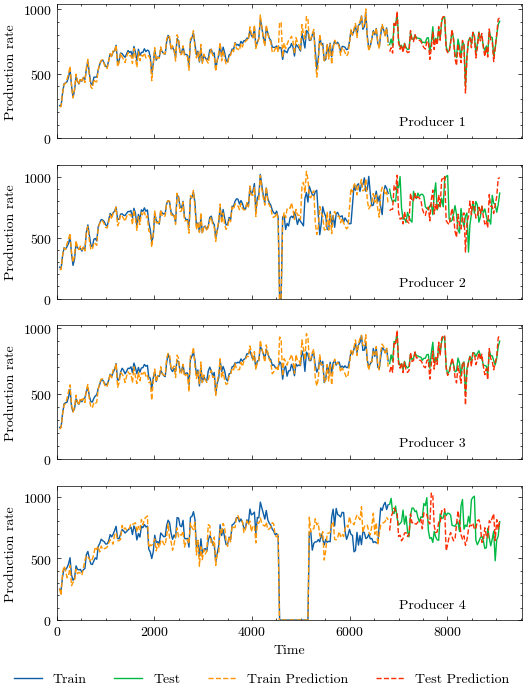

In [17]:
fig, axes = plt.subplots(len(prod.columns), figsize=(6, 8), sharex=True)

for i, p in enumerate(prod):
    axes[i].plot(time_train, prod_shut_in_train[:,p], label=f"Train")
    axes[i].plot(time_test, prod_shut_in_test[:,p], label=f"Test")
    axes[i].plot(time_train, q_hat_sh_train[:,p], ls="--", label=f"Train Prediction")
    axes[i].plot(time_test, q_hat_sh_test[:,p], ls="--", label=f"Test Prediction")
    axes[i].set(xlim=(0, None), ylim=(0, None), ylabel="Production rate")
    axes[i].annotate(f"Producer {p+1}", xy=(7000, 100))
axes[i].set(xlabel="Time")

legend = axes[i].legend(bbox_to_anchor =(1, -0.3), ncol=4)

fig = plt.show()

In [18]:
connectivity = pd.DataFrame(
    proxy_crm.lambda_ip.reshape(4,5),
    index=prod.columns.rename("Producer"),
    columns=inj.columns.rename("Injector"),
)
connectivity.T.style.highlight_max(color='blue').format("{:.2}")

Producer,0,1,2,3
Injector,,,,
0,0.33,0.33,0.17,0.17
1,0.32,0.17,0.32,0.17
2,0.25,0.25,0.25,0.25
3,0.17,0.33,0.17,0.33
4,0.18,0.18,0.34,0.34


In [19]:
shut_in_connectivity = pd.DataFrame(
    shut_in_test.lambda_ip.reshape(4,5),
    index=prod.columns.rename("Producer"),
    columns=inj.columns.rename("Injector"),
)
shut_in_connectivity.T.style.highlight_max(color='blue').format("{:.2}")

Producer,0,1,2,3
Injector,,,,
0,0.36,0.28,0.23,0.1
1,0.36,0.24,0.41,0.12
2,0.32,0.33,0.35,0.0
3,0.19,0.32,0.2,0.18
4,0.0,0.056,0.042,0.84


In [20]:
def rmse(test, pred, test_sh, pred_sh):
  original_rmse = np.sqrt(((test-pred)**2/len(test)).sum())
  shut_in_rmse = np.sqrt(((test_sh-pred_sh)**2/len(test_sh)).sum())
  return original_rmse, shut_in_rmse

result=[]
for j in range(prod.shape[1]):
  result.append(np.array(rmse(prod_test[:,j], q_hat_test[:,j], prod_shut_in_test[:,j], q_hat_sh_test[:,j])))

print(np.array(result))

[[ 10.16174306  27.84343293]
 [ 10.75875694 139.82155288]
 [ 10.05491833  41.28654067]
 [ 10.6541812  143.11082509]]


In [21]:
lambda_ip = np.tile(proxy_crm.lambda_ip.reshape((4,5)), (222,1,1))

mask = pCRM.sh_mask(prod_shut_in_train)
result = pCRM.calc_sh_mask(lambda_ip, mask)

print(result)

[[[0.33203275 0.3242568  0.24536481 0.16621398 0.1804843 ]
  [0.3320865  0.16553844 0.24520287 0.32515027 0.1805979 ]
  [0.17375437 0.32444839 0.24545076 0.16634405 0.33844695]
  [0.17343428 0.16661024 0.24552671 0.32534107 0.33795578]]

 [[0.33203275 0.3242568  0.24536481 0.16621398 0.1804843 ]
  [0.3320865  0.16553844 0.24520287 0.32515027 0.1805979 ]
  [0.17375437 0.32444839 0.24545076 0.16634405 0.33844695]
  [0.17343428 0.16661024 0.24552671 0.32534107 0.33795578]]

 [[0.33203275 0.3242568  0.24536481 0.16621398 0.1804843 ]
  [0.3320865  0.16553844 0.24520287 0.32515027 0.1805979 ]
  [0.17375437 0.32444839 0.24545076 0.16634405 0.33844695]
  [0.17343428 0.16661024 0.24552671 0.32534107 0.33795578]]

 [[0.33203275 0.3242568  0.24536481 0.16621398 0.1804843 ]
  [0.3320865  0.16553844 0.24520287 0.32515027 0.1805979 ]
  [0.17375437 0.32444839 0.24545076 0.16634405 0.33844695]
  [0.17343428 0.16661024 0.24552671 0.32534107 0.33795578]]

 [[0.33203275 0.3242568  0.24536481 0.16621398 0

In [22]:
pd.options.display.max_rows = 4000
df_lambda = ['Prod 1', 'Prod 2', 'Prod 3', 'Prod 4']
Dictionary = {}
for j in range(prod.shape[1]):
  print(result[:,j,:])

[[0.33203275 0.3242568  0.24536481 0.16621398 0.1804843 ]
 [0.33203275 0.3242568  0.24536481 0.16621398 0.1804843 ]
 [0.33203275 0.3242568  0.24536481 0.16621398 0.1804843 ]
 [0.33203275 0.3242568  0.24536481 0.16621398 0.1804843 ]
 [0.33203275 0.3242568  0.24536481 0.16621398 0.1804843 ]
 [0.33203275 0.3242568  0.24536481 0.16621398 0.1804843 ]
 [0.33203275 0.3242568  0.24536481 0.16621398 0.1804843 ]
 [0.33203275 0.3242568  0.24536481 0.16621398 0.1804843 ]
 [0.33203275 0.3242568  0.24536481 0.16621398 0.1804843 ]
 [0.33203275 0.3242568  0.24536481 0.16621398 0.1804843 ]
 [0.33203275 0.3242568  0.24536481 0.16621398 0.1804843 ]
 [0.33203275 0.3242568  0.24536481 0.16621398 0.1804843 ]
 [0.33203275 0.3242568  0.24536481 0.16621398 0.1804843 ]
 [0.33203275 0.3242568  0.24536481 0.16621398 0.1804843 ]
 [0.33203275 0.3242568  0.24536481 0.16621398 0.1804843 ]
 [0.33203275 0.3242568  0.24536481 0.16621398 0.1804843 ]
 [0.33203275 0.3242568  0.24536481 0.16621398 0.1804843 ]
 [0.33203275 0